In [2]:
import sys
import os
script_dir = os.getcwd()
root_dir = os.path.join(os.path.dirname(os.path.abspath(script_dir)))
sys.path.append(os.path.join(os.path.dirname(os.path.abspath(script_dir))))
os.chdir(root_dir)

In [197]:
from utils.io import save_object, load_object
import pandas as pd
from sklearn.model_selection import train_test_split
import json
_VERSION="v1"

In [63]:
real_world_db_entity_mapped=pd.read_csv(f"data/real_world_db/real_world_db_entity_mapped_cancerAnnot__{_VERSION}.csv", index_col=0)
real_world_db_entity_mapped.head()

,prompt,cancer_category,cancer_type,biomarker
0,what is the first-line treatment of metastatic...,GU,"['urothelial carcinoma', 'metastatic']",['fgfr3']
1,are parp inhibitors used for patients with lei...,Sarcoma,['leiomyosarcoma'],"['dna', 'parp']"
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,['rhabdomyosarcoma'],"['alk', 'tfcp2']"
3,for a patient with cancer metastatic prostate ...,GU,"['prostate cancer', 'cancer']",['brca2']
4,for a patient with her2+ breast cancer after n...,Breast,"['breast cancer', 'disease']",['her2']


In [ ]:
val, test = train_test_split(
    real_world_db_entity_mapped,
    test_size=0.75,
    stratify=real_world_db_entity_mapped['cancer_category'],
    random_state=42
)

In [175]:
real_world_db_entity_mapped['dataset'] = None
real_world_db_entity_mapped.loc[val.index, 'dataset'] = 'validation'
real_world_db_entity_mapped.loc[test.index, 'dataset'] = 'test'
real_world_db_entity_mapped.dataset.value_counts()

dataset
test          77
validation    25
Name: count, dtype: int64

In [59]:
for split_name, split_df in zip(['Validation','Test'], [val,test]):
    print(split_name)
    print(split_df['cancer_category'].value_counts(normalize=True))
    print()

Validation
cancer_category
GU             0.20
GI             0.20
Hematologic    0.12
Breast         0.08
CNS            0.08
Sarcoma        0.08
Lung           0.08
Other          0.04
Skin           0.04
Endocrine      0.04
Unspecified    0.04
Name: proportion, dtype: float64

Test
cancer_category
GU             0.220779
GI             0.207792
Hematologic    0.116883
Breast         0.103896
CNS            0.090909
Lung           0.064935
Sarcoma        0.064935
Endocrine      0.051948
GYN            0.025974
Unspecified    0.025974
Other          0.012987
Skin           0.012987
Name: proportion, dtype: float64



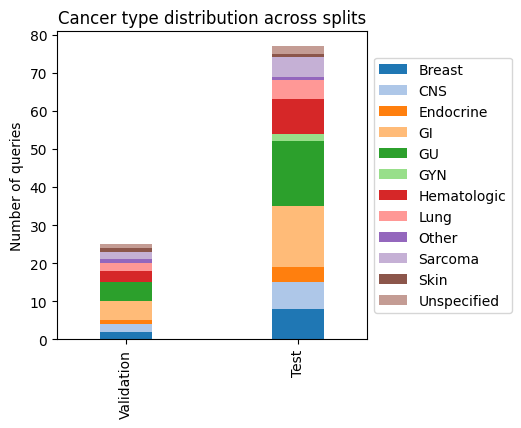

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

categories=real_world_db_entity_mapped['cancer_category'].unique()
palette = sns.color_palette("tab20", n_colors=len(categories))  # qualitative, up to 20 colors

counts = pd.DataFrame({
    'Validation': val['cancer_category'].value_counts(),
    'Test': test['cancer_category'].value_counts()
}).fillna(0)

counts.T.plot(kind='bar', stacked=True, color=palette, figsize=(4,4), width=0.3)
plt.ylabel("Number of queries")
plt.title("Cancer type distribution across splits")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [179]:
real_world_db_entity_mapped.to_csv(f"data/real_world_db/real_world_db_split__{_VERSION}.csv")
real_world_db_entity_mapped.head()

,prompt,cancer_category,cancer_type,biomarker,dataset
0,what is the first-line treatment of metastatic...,GU,"['urothelial carcinoma', 'metastatic']",['fgfr3'],test
1,are parp inhibitors used for patients with lei...,Sarcoma,['leiomyosarcoma'],"['dna', 'parp']",test
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,['rhabdomyosarcoma'],"['alk', 'tfcp2']",validation
3,for a patient with cancer metastatic prostate ...,GU,"['prostate cancer', 'cancer']",['brca2'],test
4,for a patient with her2+ breast cancer after n...,Breast,"['breast cancer', 'disease']",['her2'],test


In [178]:
with open(f"data/real_world_db/real_world_validation_query__{_VERSION}.json", "w") as f:
    json.dump(val['prompt'].tolist(), f)

with open(f"data/real_world_db/real_world_test_query__{_VERSION}.json", "w") as f:
    json.dump(test['prompt'].tolist(), f)

Create ground-truth answers

In [187]:
real_world_db=pd.read_csv(f"data/real_world_db/updated_real_world_queries_answers__{_VERSION}.csv", index_col=0)
real_world_db=real_world_db.dropna(subset='Questions').reset_index(drop=True)
real_world_db_entity_mapped['All_onlabel_groundtruth_therapies_cleaned__v2'] = None

In [188]:
def parse_therapies(entry):
    if isinstance(entry, str):
        parts = entry.split(',')
        if len(parts) > 1:
            return [set(d.strip().split(' + ')) for d in parts]
        else:
            return [set(parts)]
    else:
        return []
    
real_world_db_entity_mapped['All_onlabel_groundtruth_therapies_cleaned__v2']=real_world_db['All_onlabel_groundtruth_therapies_cleaned__v1'].apply(parse_therapies)

In [189]:
real_world_db_entity_mapped.head()

,prompt,cancer_category,cancer_type,biomarker,dataset,All_onlabel_groundtruth_therapies_cleaned__v2
0,what is the first-line treatment of metastatic...,GU,"['urothelial carcinoma', 'metastatic']",['fgfr3'],test,[{erdafitinib}]
1,are parp inhibitors used for patients with lei...,Sarcoma,['leiomyosarcoma'],"['dna', 'parp']",test,[]
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,['rhabdomyosarcoma'],"['alk', 'tfcp2']",validation,[]
3,for a patient with cancer metastatic prostate ...,GU,"['prostate cancer', 'cancer']",['brca2'],test,"[{abiraterone acetate, niraparib, prednisolone..."
4,for a patient with her2+ breast cancer after n...,Breast,"['breast cancer', 'disease']",['her2'],test,[{trastuzumab emtansine}]


In [ ]:
real_world_db_entity_mapped.to_csv(f"data/real_world_db/real_world_db__{_VERSION}.csv")

In [198]:
real_world_query_therapy_pair_dict= dict(zip(real_world_db_entity_mapped['prompt'], real_world_db_entity_mapped['All_onlabel_groundtruth_therapies_cleaned__v2']))

save_object(real_world_query_therapy_pair_dict, f"data/real_world_db/real_world_query_therapy_pair_dict.pkl")